In [1]:
import numpy as np
import pickle

from sr_gp_methods import gp, gpshap, gpcmi, new_method
from datasets import load_datasets
from pysr_utils import results_to_dataframe, plot_results, nrmse_loss

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set_theme()
warnings.filterwarnings("ignore", category=UserWarning, module="pysr")
warnings.filterwarnings("ignore", category=RuntimeWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [14]:
dataset_names = [
    # "F1",
    # "F2",
    # ("4544_GeographicalOriginalofMusic", "4544_GOM"),
    # "505_tecator",
#     ("Communities and Crime", "CCN"),
    ("Communities and Crime Unnormalized", "CCUN"),
]

datasets = load_datasets(dataset_names)
width = max([round(len(name)+10, -1) for name in datasets.keys()])

datasets.keys()

dict_keys(['CCUN'])

In [4]:
n_submodels = 3
top_features_ratio = None #0.05

pysr_params = {
    "populations": 5,
    "population_size": 20,
    "niterations": 150,
    "binary_operators": ["+", "-", "*"],
    "unary_operators": ["sqrt", "inv(x) = 1/x"],
    "extra_sympy_mappings": {"inv": lambda x: 1/x},
    "verbosity": 0
}

cmi_fs_params = {
    "k": 5,
    "top_features_ratio": None,
    # "min_relative_mi_gain": 0.2,
    "alpha": 0.01,  # Significance level for CMI
}

basic_params = {
    "loss_function": nrmse_loss,
    "n_runs": 10,
    "record_interval": 5,
    "pysr_params": pysr_params
}

In [16]:
results = {}
features = {}
equations = {}

for dataset_name, dataset in datasets.items():
    title = f"{dataset_name}"
    print("*" * width)
    print(f"|{title.center(width - 2)}|")
    print("*" * width)
    
    X = dataset['X']
    y = dataset['y']

    basic_params.update({"X": X, "y": y})

    results[dataset_name] = {}
    features[dataset_name] = {}
    equations[dataset_name] = {}

    # Run GP and store results
    # temp_results, features[dataset_name]['GP'], equations[dataset_name]['GP'], train_val_test_sets_list = gp(**basic_params)
    # results[dataset_name].update(temp_results)
    
    # # Run GPSHAP and store results
    # temp_results, features[dataset_name]['GPSHAP'], equations[dataset_name]['GPSHAP'] = gpshap(
    #     **basic_params,
    #     top_features_ratio=top_features_ratio,
    #     gp_best_equations=equations[dataset_name]['GP'],
    #     train_val_test_sets_list=train_val_test_sets_list,
    # )
    # results[dataset_name].update(temp_results)

    # Run GPCMI and store results
    temp_results, features[dataset_name]["gpCMI"], equations[dataset_name]["gpCMI"] = gpcmi(
        **basic_params,
        fs_params=cmi_fs_params,
    )
    results[dataset_name].update(temp_results)

    # Run new_method and store results
    temp_results, features[dataset_name]["gpNEW"], equations[dataset_name]["gpNEW"] = new_method(
        **basic_params,
        n_submodels=n_submodels,
        fs_params=cmi_fs_params,
    )
    results[dataset_name].update(temp_results)

    print()

**********
|  CCUN  |
**********
gpCMI --------------
.......... 10
gpNEW --------------
.......... 10



In [27]:
data = (results, features, equations)
pickle.dump(data, open("data.pickle", "wb"))

In [2]:
results, features, equations = pickle.load(open("data.pickle", "rb"))

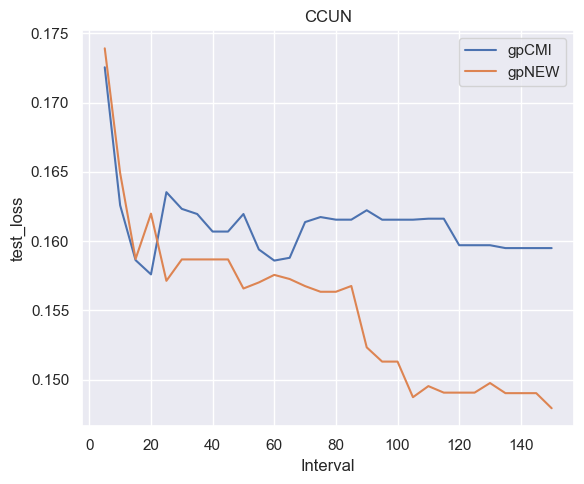

In [7]:
# metrics = 'training_loss'
# metrics = 'validation_loss'
metrics = 'test_loss'
n_datasets = len(results)
record_interval = basic_params['record_interval']
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))

    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.nanmedian(dataset_results[method][metrics], axis=0),
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Interval")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
plt.tight_layout()

plt.show()

In [8]:
from copy import deepcopy

results_copy = deepcopy(results)

for dataset_name in results.keys():
    for method in results[dataset_name].keys():
        for metric in results[dataset_name][method].keys():
            results_copy[dataset_name][method][metric] = results[dataset_name][method][metric][:, -1]

In [16]:
df_results

dataset          CCUN                                                          \
method          gpCMI                                   gpNEW                   
metric  training_loss validation_loss test_loss training_loss validation_loss   
run                                                                             
0            0.125209        0.119160  0.184199      0.121044        0.145056   
1            0.131281        0.142641  0.130893      0.110603        0.134642   
2            0.126722        0.166248  0.140458      0.106895        0.134880   
3            0.111187        0.169457  0.160434      0.132777        0.148527   
4            0.139279        0.154184  0.124771      0.141959        0.117491   
5            0.127720        0.127540  0.158568      0.119000        0.162492   
6            0.131601        0.154819  0.138872      0.135221        0.127826   
7            0.118603        0.108481  0.211774      0.120076        0.176673   
8            0.108251        0.145313  0.164680      0.118306        0.143084   
9            0.133713        0.136559  0.160852      0.119767        0.123899   

dataset            
method             
metric  test_loss  
run                
0        0.147371  
1        0.147558  
2        0.172221  
3        0.132711  
4        0.172079  
5        0.143753  
6        0.180240  
7        0.136159  
8        0.184511  
9        0.148339

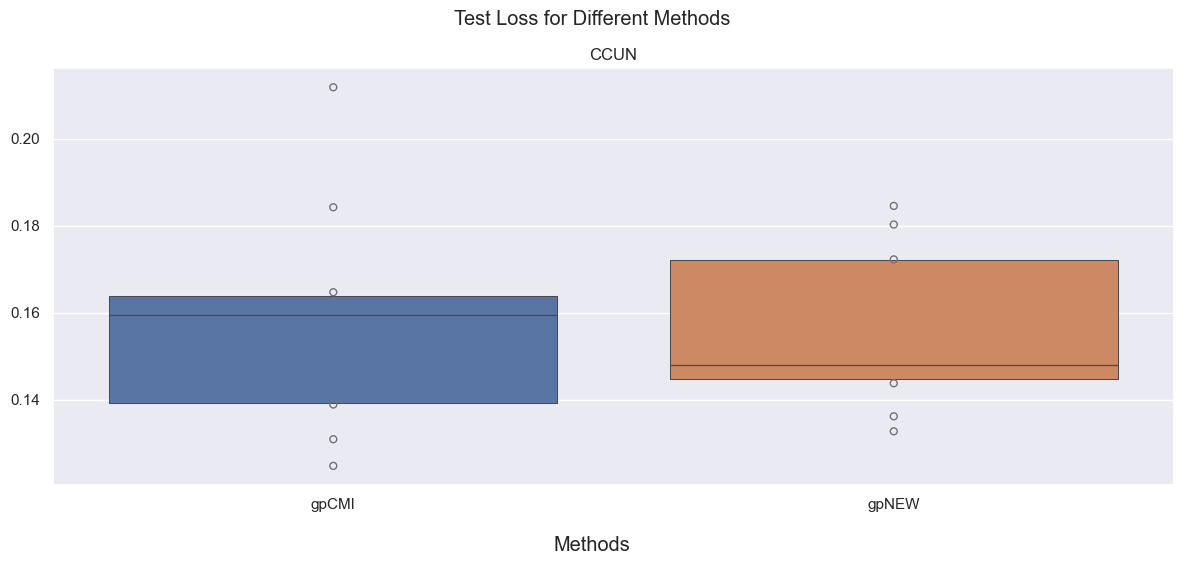

In [17]:
# Convert results to DataFrame    
df_results = results_to_dataframe(results_copy)

fig, axes = plot_results(
    df_results, 
    # nrows=2, 
    # ncols=None, 
    # group_level="model",
    # value_level="metric", 
    # value_key="test_loss"
    # value_key="validation_loss",
    # value_key="training_loss"
)

fig.figure.set_size_inches(12, 5)
fig.tight_layout(w_pad=0.5)
fig.suptitle("Test Loss for Different Methods", y=1.04)
# fig.supylabel("Test Loss", x=-.02)
fig.supxlabel("Methods", y=-.05)

# axes[0].set_ylim(-.001, 0.2)
# axes[1].set_ylim(.1, 0.2)
plt.show()

In [21]:
for dataset_name in features.keys():
    print(f"{dataset_name} features:")
    for method in features[dataset_name].keys():
        a = features[dataset_name][method]

        if isinstance(a[0], str):
            print(f"{method}: {len(a)}")
        else:

            if isinstance(a[0][0], str):
                b = list(map(lambda x: len(x), a))
                mean_x = np.mean(b)
            else:
                c = list(map(lambda x: len(set([item for sublist in x for item in sublist])), features[dataset_name][method]))
                mean_x = np.mean(c)

            print(f"{method}: {mean_x:.0f}")
    print()
            

CCUN features:
gpCMI: 12
gpNEW: 30



In [22]:
equations['CCUN']['gpNEW'][0][1].sympy_format.simplify()

pctPolicAsian*pctVacantBoarded*sqrt(policCarsAvail)

In [19]:
len(features['CCUN']['gpNEW'][3][1])

7